In [1]:
import sys, importlib, time
sys.path.append('../../')
#sys.path.append('../../src/')

from src.Modules.Utils.Imports import *
from src.Modules.Models.BuildBINNs import BINN
from src.Modules.Utils.ModelWrapper import ModelWrapper
from src.Modules.Utils.Gradient import Gradient

import src.Modules.Utils.PDESolver as PDESolver
import src.Modules.Loaders.DataFormatter as DF

from src.DE_simulation import fickian_diffusion, Diffusion_eqn, simple_pulling_diffusion, simple_adhesion_diffusion
from scipy.integrate import odeint
import matplotlib.patches as mpatches

device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))

# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

def initialize_param_plot():
    
    fig = plt.figure(figsize=(3.75*2,4*1))

    ylabels = [r'Diffusivity (mm$^2$/wk)', r'Growth (1/wk)']
    xlabels = ['Cell density (Normalized)','Cell density (Normalized)']
    titles = [r'$D$', r'$G$']
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    axs = [ax1,ax2]

    fontsize=15

    #iterate through axes and set xlabel, ylabel, title
    for ax, ylabel, xlabel, title in zip(axs, ylabels,xlabels, titles):
        ax.set_ylabel(ylabel,fontsize=fontsize)
        ax.set_xlabel(xlabel,fontsize=fontsize)
        ax.set_title(title,fontsize=fontsize)
    for ax in axs:
        ax.grid()
        
    return fig, axs

def load_model(binn_name, x, t, save_name):

    # instantiate BINN
    binn = BINN(binn_name,x, t).to(device)

    # wrap model and load weights
    parameters = binn.parameters()
    model = ModelWrapper(
        model=binn,
        optimizer=None,
        loss=None,
        save_name=save_name)
    
    #model.save_name += '_' + binn.name + weight
    model.save_name += weight
    model.load(model.save_name + '_model', device=device)

    return model, binn


def recover_binn_params(binn):
    # learned diffusion term
    def D(u):
        D = binn.diffusion(to_torch(u)[:, None])
        return to_numpy(D).reshape(-1)

    # learned growth term
    def G(u):
        r = binn.growth(to_torch(u)[:, None])
        return to_numpy(r).reshape(-1)  

    return D, G

def DE_sim(x, t, q, IC, Diffusion_function):
    
    sol = odeint(Diffusion_eqn, IC, t, args=(x, q, Diffusion_function))
    sol = sol.T
    return sol


Device set to cpu


/home/hpc/nardinij/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
path = "../../data/"

Pinteraction = 0.5
Pm = 1.0
Pp = 0.0

params = (Pm,Pp,Pinteraction)
filename_header = "simple_pulling_mean_25"
suptitle = "Ppull"

### BINN model information
save_folder = "../../Weights/"
model_name = 'DMLP'
weight = '_best_val'
surface_weight = 1.0
pde_weight = 1e4

file_name = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Ppull_{ Pinteraction}'    

### load in data
inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)
outputs = outputs.reshape(shape)
x = np.unique(inputs[:,0])
t = np.unique(inputs[:,1])
binn_name  = f"{model_name}"
binn_save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
model,binn = load_model(binn_name=binn_name,save_name=save_folder + binn_save_name,x=x,t=t)
ANN_save_name =  f"SF_only_{binn_name}_training_replicate_0_{file_name}_pde_weight_{pde_weight}"
model,ANN = load_model(binn_name=binn_name,save_name=save_folder + ANN_save_name,x=x,t=t)


In [3]:
### Generate ANN, BINN, and PDE predictions
binn_prediction = to_numpy(binn.surface_fitter(to_torch(inputs)))
binn_prediction = binn_prediction.reshape(shape)

ANN_prediction = to_numpy(ANN.surface_fitter(to_torch(inputs)))
ANN_prediction = ANN_prediction.reshape(shape)

file_name = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Ppull_{Pinteraction}_pde_weight_{pde_weight}'
pde_mat = np.load(f"../../results/PDE_sims/PDE_sim_{binn_name}_{file_name}.npy",allow_pickle=True).item()
pde_prediction =  pde_mat['U_sim']

q = [Pm/4,Pinteraction]
IC = outputs[:,0]
MF_PDE = DE_sim(x, 
        t, 
        q, 
        IC, 
        Diffusion_function = simple_pulling_diffusion)

In [4]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
fontsize = 30

def MSE(a,b):
    assert a.shape == b.shape
    return ((a - b)**2).mean()

def plot_sol_data(x,t,sol1,sol2,sol3,U):
    
    fig, axes = plt.subplots(1,3,figsize=(18,6),layout='constrained')

    count = 0
    for i in [33, 66, 99]:
        axes[count].plot(x,sol1[:,i],"-", linewidth=8,  c = colors[3], label = "ANN prediction")
        axes[count].plot(x,sol2[:,i],"-.",linewidth=5, c = colors[4], label = "BINN prediction")
        axes[count].plot(x,sol3[:,i],"--",linewidth=5, c = colors[1], label = "PDE prediction")
        
        if i <= 75: 
            m = "o" 
            mcolor = "black"
        else: 
            m ="s"
            mcolor = (.4,.4,.4)
        axes[count].plot(x[::2],U[::2,i],m,color=mcolor,markersize=10,label="Data")

        axes[count].set_xlabel("Space ($x$)",fontsize=fontsize)
        if count ==0: axes[count].set_ylabel("Density",fontsize=fontsize)
        axes[count].set_title(f"t = {round(t[i],1)}",fontsize=fontsize)
        
        axes[count].set_ylim([-.05,0.63])
        axes[count].set_xticks([0,100,200])
        axes[count].set_yticks([0,0.3,0.6])
        axes[count].set_xticklabels([0,100,200],fontsize=25)
        axes[count].set_yticklabels([0,0.3,0.6],fontsize=25)
        
        count+=1
    
    rect=mpatches.Rectangle((125,-0.01),75,.301, 
                        fill = False,
                        color = "black",
                        linewidth = 1)
    plt.gca().add_patch(rect)
    plt.savefig(f"../../results/figures/ANN_BINN_PDE_prediction.png",format="png")
    
    return fig, axes

def plot_sol_data_ZOOM(x,t,sol1,sol2,sol3,U):
    
    fig, axes = plt.subplots(1,1,figsize=(6,6))

    count = 0
    for i in [99]:
        axes.plot(x,sol1[:,i],"-", linewidth=8,  c = colors[3], label = "ANN prediction")
        axes.plot(x,sol2[:,i],"-.",linewidth=5, c = colors[4], label = "BINN prediction")
        axes.plot(x,sol3[:,i],"--",linewidth=5, c = colors[1], label = "PDE prediction")
        
        if i <= 75: 
            m = "o" 
            mcolor = "black"
        else: 
            m ="s"
            mcolor = (.3,.3,.3)
        axes.plot(x[::2],U[::2,i],m,color=mcolor,markersize=10,label="Data")
        
        count+=1
    axes.set_xticks([])
    axes.set_yticks([])
    #axes.set_xlim([110,200])
    #axes.set_ylim([-.01,0.4])
    axes.set_xlim([125,200])
    axes.set_ylim([-.01,0.3])
    plt.savefig(f"../../results/figures/ANN_BINN_PDE_prediction_ZOOM.png",format="png")
    return fig, axes


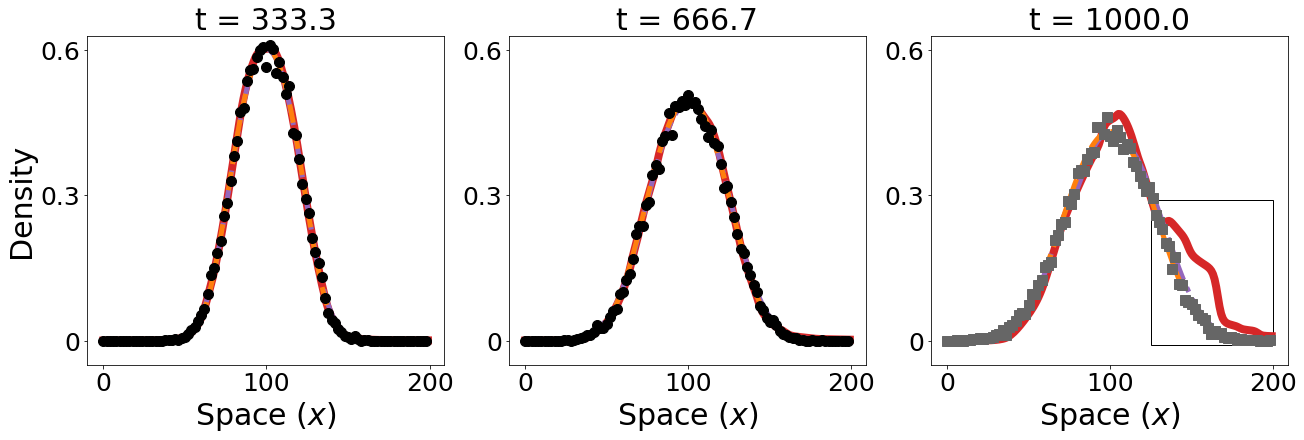

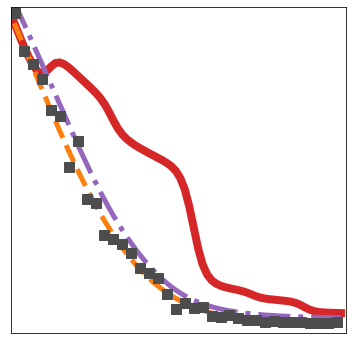

In [5]:
fig2,ax2 = plot_sol_data(x,t,ANN_prediction, binn_prediction, pde_prediction, outputs)
fig2,ax2 = plot_sol_data_ZOOM(x,t,ANN_prediction, binn_prediction, pde_prediction,  outputs)

In [20]:
tmax = np.max(t)
print(MSE(ANN_prediction[:,t<=.75*tmax],outputs[:,t<=.75*tmax]), 
      MSE(binn_prediction[:,t<=.75*tmax],outputs[:,t<=.75*tmax]), 
      MSE(pde_prediction[:,t<=.75*tmax],outputs[:,t<=.75*tmax]),
      MSE(MF_PDE[:,t<=.75*tmax],outputs[:,t<=.75*tmax]))
print("")
print(MSE(ANN_prediction[:,t>.75*tmax],outputs[:,t>.75*tmax]), 
      MSE(binn_prediction[:,t>.75*tmax],outputs[:,t>.75*tmax]), 
      MSE(pde_prediction[:,t>.75*tmax],outputs[:,t>.75*tmax]),
      MSE(MF_PDE[:,t>.75*tmax],outputs[:,t>.75*tmax]))

0.00011693754245157489 9.318276128458122e-05 7.639076737844356e-05 7.451239494654814e-05

0.0009361875121993979 0.00014712270118736985 0.00010194413353343004 0.0001004738437486512


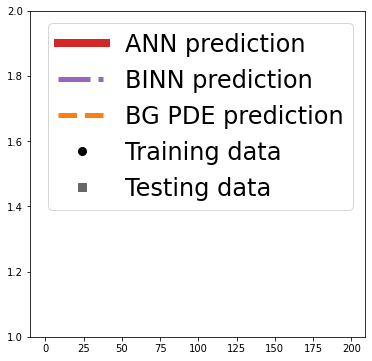

In [6]:
fig, axes = plt.subplots(1,1,figsize=(6,6))
i = 0
axes.plot(x,ANN_prediction[:,i],"-", linewidth=8,  c = colors[3], label = "ANN prediction")
axes.plot(x,binn_prediction[:,i],"-.",linewidth=5, c = colors[4], label = "BINN prediction")
axes.plot(x,pde_prediction[:,i],"--",linewidth=5, c = colors[1], label = "BG PDE prediction")


m = "o" 
mcolor = "black"
axes.plot(x[::4],outputs[::4,i],m,color=mcolor,markersize=8,label="Training data")
m ="s"
mcolor = (.4,.4,.4)
axes.plot(x[::4],outputs[::4,i],m,color=mcolor,markersize=8,label="Testing data")
axes.set_ylim([1,2])

plt.legend(fontsize=24)